In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import glob
import os
from PIL import Image

import tensorflow as tf

2024-01-21 17:10:37.757512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 17:10:38.228315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/siemieniuk/miniconda3/envs/fingerprints/lib/python3.10/site-packages/cv2/../../lib64:
2024-01-21 17:10:38.228374: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-21 17:10:38.314102: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

In [2]:
def imshow(img: np.ndarray, in_bgr: bool = True):
    if in_bgr:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(img)
    display(image)

In [3]:
PATH_TO_INPUT = "./data/training_input"
PATH_TO_MIN_INPUT = "./data/min_input"
PATH_TO_TRUTH = "./data/training_ground-truth"
PATH_TO_MIN_TRUTH = "./data/min_ground-truth"
filenames = glob.glob("*", root_dir=PATH_TO_INPUT)

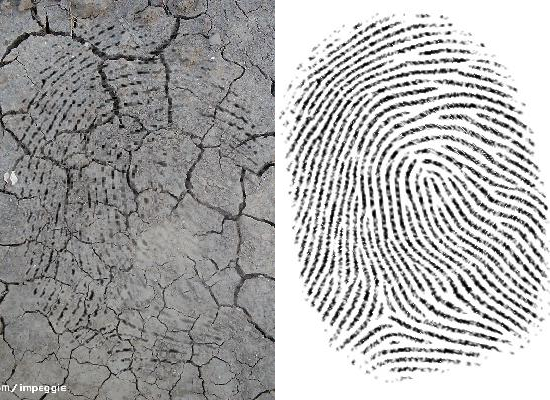

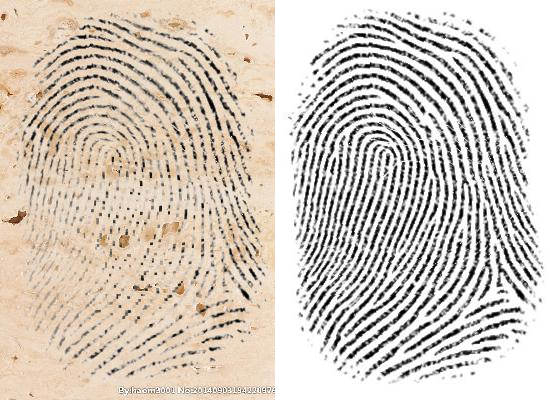

In [4]:
random_filenames = np.random.choice(filenames, 2)
for fname in random_filenames:
    img_input = cv2.imread(os.path.join(PATH_TO_INPUT, fname), cv2.IMREAD_UNCHANGED)
    img_truth = cv2.imread(os.path.join(PATH_TO_TRUTH, fname), cv2.IMREAD_UNCHANGED)
    img_truth = cv2.cvtColor(img_truth, cv2.COLOR_GRAY2BGR)
    imshow(np.concatenate([img_input, img_truth], axis=1))

In [5]:
import importlib

import data_loading as load
importlib.reload(load)

import data_preprocessing as prep

In [6]:
input_func_list = [prep.normalize_pixels]
truth_func_list = [prep.invert, prep.to_grayscale, prep.normalize_pixels]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=4, seed=42)

In [12]:
train_ds = ds_factory.create_dataset(PATH_TO_INPUT, PATH_TO_TRUTH)
min_ds = ds_factory.create_dataset(PATH_TO_MIN_INPUT, PATH_TO_MIN_TRUTH)

Found 75600 files belonging to 1 classes.
Found 75600 files belonging to 1 classes.
Found 250 files belonging to 1 classes.
Found 250 files belonging to 1 classes.


2024-01-21 17:12:14.166216: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: ./data/min_ground-truth/20204.jpg; No such file or directory
2024-01-21 17:12:14.166269: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: ./data/min_ground-truth/20267.jpg; No such file or directory
2024-01-21 17:12:14.166307: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: ./data/min_ground-truth/2035.jpg; No such file or directory


In [8]:
input_batch, truth_batch = next(train_ds.as_numpy_iterator())
input_batch.shape, truth_batch.shape

((4, 400, 275, 3), (4, 400, 275, 1))

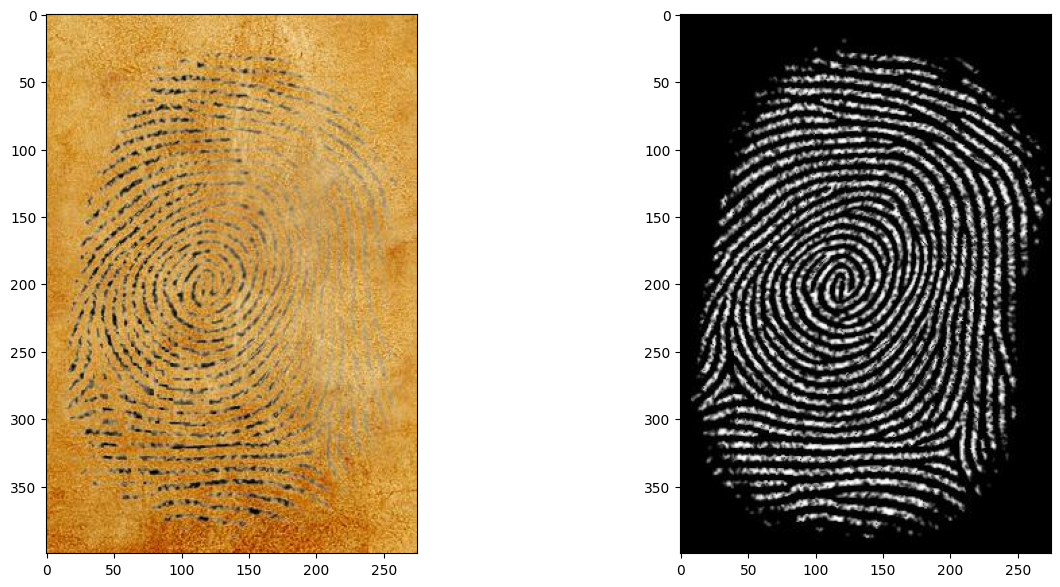

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(input_batch[3])
axs[1].imshow(truth_batch[3], cmap="gray", vmin=0, vmax=1)

In [10]:
from models import get_unet
unet_model = get_unet(3)
unet_model.compile(optimizer='adam', loss=['mse'])

In [14]:
history = unet_model.fit(min_ds, epochs=10)

Epoch 1/10
63/63 [==============================] - 254s 4s/step - loss: 0.0817
Epoch 2/10
63/63 [==============================] - 268s 4s/step - loss: 0.0610
Epoch 3/10
63/63 [==============================] - 222s 4s/step - loss: 0.0566
Epoch 4/10
63/63 [==============================] - 249s 4s/step - loss: 0.0527
Epoch 5/10
63/63 [==============================] - 272s 4s/step - loss: 0.0501
Epoch 6/10
63/63 [==============================] - 277s 4s/step - loss: 0.0484
Epoch 7/10
63/63 [==============================] - 295s 5s/step - loss: 0.0464
Epoch 8/10
63/63 [==============================] - 319s 5s/step - loss: 0.0449
Epoch 9/10
63/63 [==============================] - 282s 4s/step - loss: 0.0439
Epoch 10/10
63/63 [==============================] - 246s 4s/step - loss: 0.0422


In [33]:
to_predict = next(iter(train_ds))[0]
res = unet_model.predict(next(iter(train_ds))[0])

1/1 [==============================] - 1s 1s/step


In [34]:
img = tf.keras.utils.img_to_array(res[0])
img = np.repeat(img, 3, axis=-1)
img = ((1 - img) * 255.0).astype(np.uint8)

to_predict = tf.keras.utils.img_to_array(to_predict[0])
to_predict = ((1 - to_predict) * 255.0).astype(np.uint8)

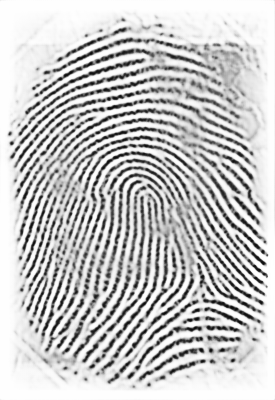

In [35]:
imshow(img)

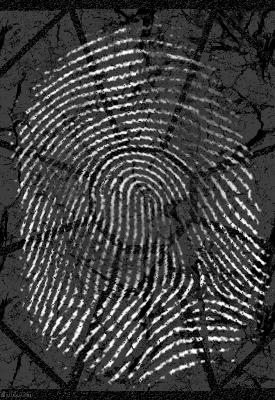

In [36]:
imshow(to_predict)